# Previsão de vendas do varejo utilizando a biblioteca Prophet da empresa Meta

### Objetivo do trabalho:
#### Utilizar a biblioteca Prophet para prever os dados de venda do verejo coletados de banco de dados de uso público para 365 dias após a última observação da base de dados.

### Importando as bibliotecas necessárias para o trabalho

In [1]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt 
from prophet.plot import plot_plotly, plot_components_plotly

# Previsão de séries temporais
from sklearn.metrics import mean_squared_error
from prophet import Prophet

In [2]:
# Leitura do arquivos csv e Criação do dataframe

df = pd.read_csv('retail_sales.csv')

In [3]:
# Carregando informações do cabeçalho para entender quais são as variáveis contidas no dataframe
df.head()

,Store ID,Product ID,Date,Units Sold,Sales Revenue (USD),Discount Percentage,Marketing Spend (USD),Store Location,Product Category,Day of the Week,Holiday Effect
0,Spearsland,52372247,2022-01-01,9,2741.69,20,81,Tanzania,Furniture,Saturday,False
1,Spearsland,52372247,2022-01-02,7,2665.53,0,0,Mauritania,Furniture,Sunday,False
2,Spearsland,52372247,2022-01-03,1,380.79,0,0,Saint Pierre and Miquelon,Furniture,Monday,False
3,Spearsland,52372247,2022-01-04,4,1523.16,0,0,Australia,Furniture,Tuesday,False
4,Spearsland,52372247,2022-01-05,2,761.58,0,0,Swaziland,Furniture,Wednesday,False


De forma preliminar, é possível entender que a base de dados possui a soma das unidades vendidas por loja a cada dia. Para melhor análise, os dados também registraram o dia da semana, além do fator 'feriado', que pode trazer algum tipo de discrepância em relação aos dias da semana. O dataframe também determina a localização e a categoria de produto vendida, abrindo um leque de possibilidades para o uso de previsão. Sendo assim, o ideal neste momento é definir o alvo da análise, tornando a previsão mais confiável e menos abrangente.

In [4]:
# Identificando os tipos e a dimensão total da base de dados
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Store ID               30000 non-null  object 
 1   Product ID             30000 non-null  int64  
 2   Date                   30000 non-null  object 
 3   Units Sold             30000 non-null  int64  
 4   Sales Revenue (USD)    30000 non-null  float64
 5   Discount Percentage    30000 non-null  int64  
 6   Marketing Spend (USD)  30000 non-null  int64  
 7   Store Location         30000 non-null  object 
 8   Product Category       30000 non-null  object 
 9   Day of the Week        30000 non-null  object 
 10  Holiday Effect         30000 non-null  bool   
dtypes: bool(1), float64(1), int64(4), object(5)
memory usage: 2.3+ MB


(30000, 11)

Analisando os tipos das variáveis e levando em conta o objetivo deste trabalho, a variável 'Date' é a única que precisará de tratamento, pois para trabalhar com séries temporais é importante transformar a variável 'Date' de 'objeto' para 'datetime' e juntamente com o inicio da limpeza dos dados, farei essa modificação.

In [5]:
# Criação de novo dataframe para evitar a manipulação dos dados originais importados no início do trabalho
df_copia = df.copy()

### Início do processo de limpeza dos dados

In [6]:
# Utilizando o novo dataframe para identificar se há valores nulos entre as observações e se sim, 
# trazer a soma dos valores nulos de cada variável
df_copia.isnull().sum()

Store ID                 0
Product ID               0
Date                     0
Units Sold               0
Sales Revenue (USD)      0
Discount Percentage      0
Marketing Spend (USD)    0
Store Location           0
Product Category         0
Day of the Week          0
Holiday Effect           0
dtype: int64

Como não há valores nulos, não existe a necessidade de fazer nenhum tratamento de valores nulos

In [7]:
# Verificando se existe valores duplicados na base de dados e se sim,
# trazer a soma das observações duplicadas
df_copia.duplicated().sum()


0

Como não há valores duplicados, não existe a necessidade de fazer nenhum tratamento de observações duplicadas

In [8]:
# Modificação do tipo da variável 'Date' de objeto para datetime
df_copia['Date'] = pd.to_datetime(df_copia['Date'])

In [9]:
# Verificando alteração
df_copia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Store ID               30000 non-null  object        
 1   Product ID             30000 non-null  int64         
 2   Date                   30000 non-null  datetime64[ns]
 3   Units Sold             30000 non-null  int64         
 4   Sales Revenue (USD)    30000 non-null  float64       
 5   Discount Percentage    30000 non-null  int64         
 6   Marketing Spend (USD)  30000 non-null  int64         
 7   Store Location         30000 non-null  object        
 8   Product Category       30000 non-null  object        
 9   Day of the Week        30000 non-null  object        
 10  Holiday Effect         30000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 2.3+ MB


In [10]:
# Criando novo dataframe que apesar de não ter sido necessária grande limpeza, teve o tipo de variável modificada
df_limpo = df_copia.copy()

### Entendendo os dados através de gráficos

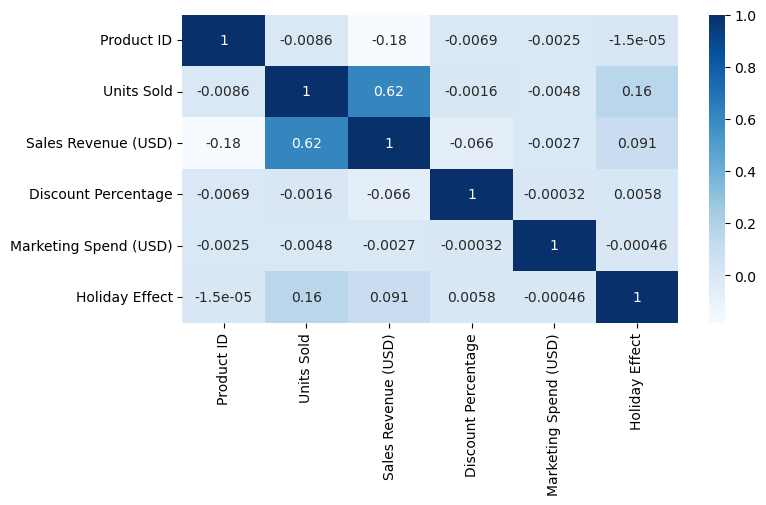

In [11]:
# Entendendo se há alguma correlação forte positiva ou forte negativa entre as variáveis

plt.figure(figsize=(8,4))
sns.heatmap(df_limpo.corr(numeric_only= True), annot=True, cmap='Blues')
plt.show()

Ainda que obviamente 'unidades vendidas' e 'valor das vendas' tenha uma forte correlação, é interessante observar que o fator feriado não tem uma correlação tão forte com essas variáveis, isso pode exigir maior investigação.

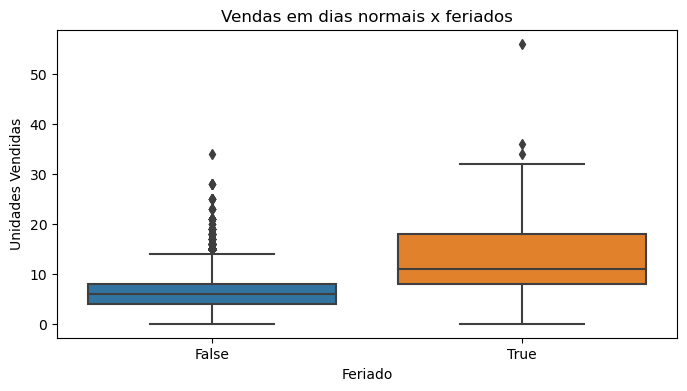

In [12]:
# Entendendo a relação entre as vendas em dias normais e feriados

plt.figure(figsize=(8,4))
sns.boxplot(x='Holiday Effect', y='Units Sold', data=df_limpo)
plt.title('Vendas em dias normais x feriados')
plt.xlabel('Feriado')
plt.ylabel('Unidades Vendidas')
plt.show()

In [13]:
#Calculando a mediana das variáveis categóricas feriado e fim de semana

mediana_feriado = df_limpo.groupby('Holiday Effect')['Units Sold'].median()
mediana_feriado

Holiday Effect
False     6.0
True     11.0
Name: Units Sold, dtype: float64

Com base nos dados, o fator feriado possui impacto significativo na quantidade de unidades vendidas.

Para enriquecer o estudo dos dados, é interessante adicionar uma nova variável booleana que pode nos dizer além do fator feriado, se o dia é final de semana ou não.

In [14]:
# Criando uma nova coluna chamada Weekend que irá apontar sempre que o dia da semana for Domingo ou Sábado
df_limpo['Weekend'] = df_limpo['Day of the Week'].isin(['Saturday', 'Sunday'])

In [15]:
df_limpo.head()

,Store ID,Product ID,Date,Units Sold,Sales Revenue (USD),Discount Percentage,Marketing Spend (USD),Store Location,Product Category,Day of the Week,Holiday Effect,Weekend
0,Spearsland,52372247,2022-01-01,9,2741.69,20,81,Tanzania,Furniture,Saturday,False,True
1,Spearsland,52372247,2022-01-02,7,2665.53,0,0,Mauritania,Furniture,Sunday,False,True
2,Spearsland,52372247,2022-01-03,1,380.79,0,0,Saint Pierre and Miquelon,Furniture,Monday,False,False
3,Spearsland,52372247,2022-01-04,4,1523.16,0,0,Australia,Furniture,Tuesday,False,False
4,Spearsland,52372247,2022-01-05,2,761.58,0,0,Swaziland,Furniture,Wednesday,False,False


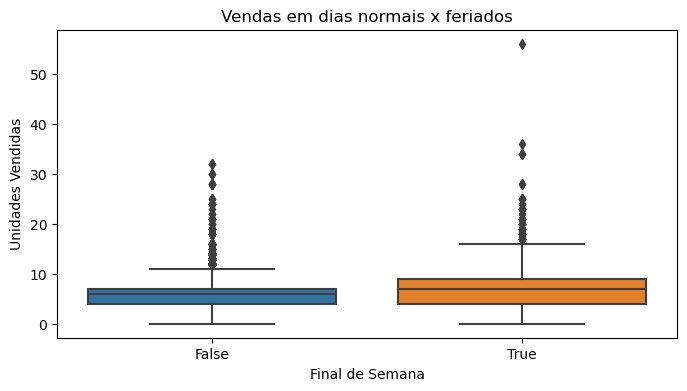

In [16]:
# Entendendo a relação entre as vendas em dias normais e finais de semana

plt.figure(figsize=(8,4))
sns.boxplot(x='Weekend', y='Units Sold', data=df_limpo)
plt.title('Vendas em dias normais x feriados')
plt.xlabel('Final de Semana')
plt.ylabel('Unidades Vendidas')
plt.show()

In [17]:
#Calculando a mediana das variáveis categóricas feriado e fim de semana

mediana_feriado = df_limpo.groupby('Weekend')['Units Sold'].median()
mediana_feriado

Weekend
False    6.0
True     7.0
Name: Units Sold, dtype: float64

Com esse gráfico e as médianas, podemos, de forma visual, perceber que o fator feriado possui uma relevância maior do que finais de semana em termos de impacto de unidades vendidas.

### Pré-analisando as vendas ao longo do tempo

In [18]:
# Verificando dados categoricos do dataframe

df_limpo.describe(include=[object])

,Store ID,Store Location,Product Category,Day of the Week
count,30000,30000,30000,30000
unique,1,243,4,7
top,Spearsland,Korea,Furniture,Saturday
freq,30000,237,9503,4310


In [19]:
# Criação de novo dataframe para trabalhar com a variável tempo e fazer posterior previsão
df_tempo = df_limpo.copy()

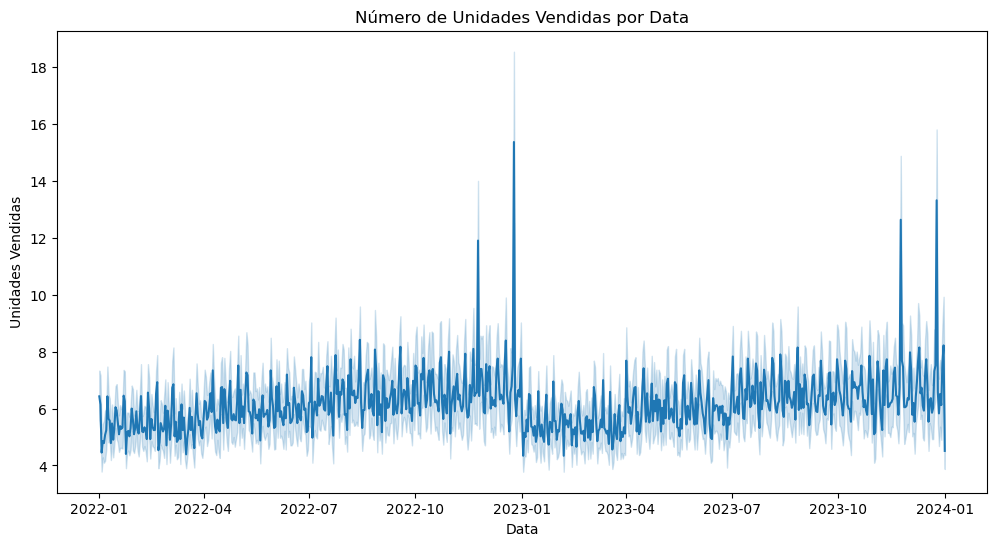

In [20]:
# Identificando se há fator de sazonalizadade 
df_tempo.groupby('Date')['Units Sold'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=df_tempo, x='Date', y='Units Sold')
plt.title('Número de Unidades Vendidas por Data')
plt.xlabel('Data')
plt.ylabel('Unidades Vendidas')
plt.show()

Através do gráfico acima é possível perceber que o aspecto sazolalidade está presente ao longo dos anos e também que há datas específicas onde as vendas dão grandes saltos. Em seguida será utilizada a biblioteca Prophet para melhor vizualização e previsão.

### Trabalhando com a biblioteca Prophet

In [21]:
# Para trabalhar com o prophet, primeiro será necessário alterar o nome de duas variáveis do dataframe
# A variável Date será chamada 'ds' e a variável Units Sold 'y', para adaptar o dataframe ao algoritmo do Prophet
df_tempo = df_tempo[['Date','Units Sold']].rename(columns = {'Date': 'ds', 'Units Sold': 'y'})

In [22]:
# Agrupando o número total de vendas de acordo com os dias
df_tempo = df_tempo.groupby('ds')['y'].sum().reset_index()

In [23]:
df_tempo.head()

,ds,y
0,2022-01-01,270
1,2022-01-02,258
2,2022-01-03,187
3,2022-01-04,204
4,2022-01-05,201


In [24]:
# Treinando modelo com os dados utilizando uma semente aleatória setada manualmente para manter a consistência dos resultados
# do modelo de machine learning, treinamento do Prophet neste caso
np.random.seed(3476)


# Instanciando um objeto da classe Prophet (modelo de previsão de séries temporais do Facebook Prophet)
modelo = Prophet()

# Ajustando o modelo ao nosso dataframe
modelo.fit(df_tempo)

# Criação de novo dataframe com datas futuras baseadas no nosso dataframe, período de 90 dias ('D') a frente
futuro = modelo.make_future_dataframe(periods=90,freq='D')

# Utilização do modelo ajustado para fazer previsões
previsao = modelo.predict(futuro)

17:41:16 - cmdstanpy - INFO - Chain [1] start processing
17:41:17 - cmdstanpy - INFO - Chain [1] done processing


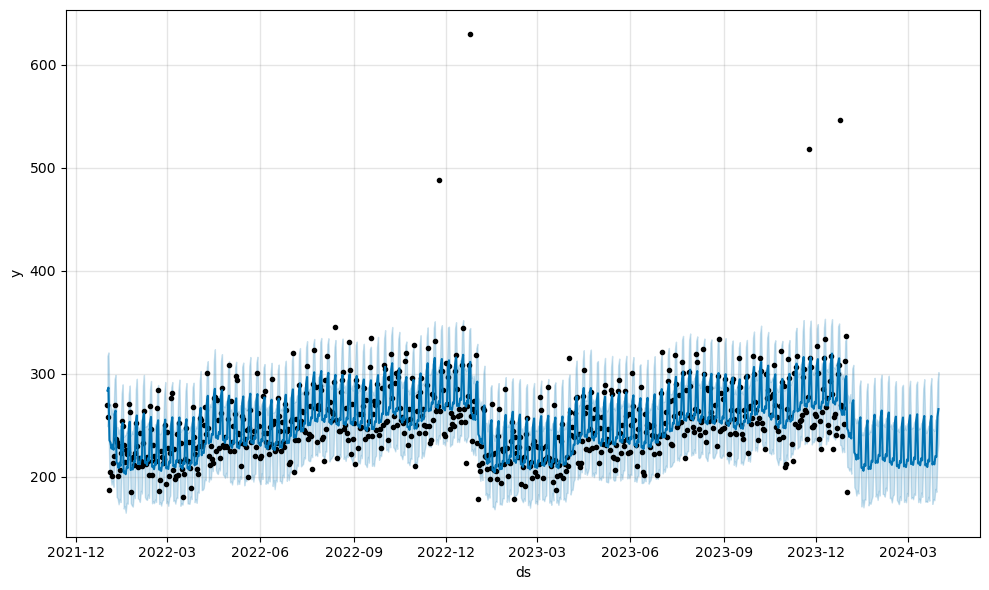

In [25]:
fig1 = modelo.plot(previsao)

Nesse primeiro gráfico, utilizando um período de 90 dias, é possível perceber que o modelo conseguiu interpretar de forma consistente o padrão de sazonalidade do dataframe

In [26]:
# Identificando a janela de valores gerados pelo algoritmo onde yhat lower são os mais baixo e yhat_upper os mais altos

previsao[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,283.517154,248.942176,317.239970
1,2022-01-02,286.433002,252.490733,320.646206
2,2022-01-03,235.218658,199.106576,271.093241
3,2022-01-04,232.986569,200.992082,270.556079
4,2022-01-05,227.163851,192.137313,260.161841
...,...,...,...,...
816,2024-03-27,211.836820,177.144766,244.343187
817,2024-03-28,219.909440,188.094927,255.586424
818,2024-03-29,219.246278,185.220792,253.427636
819,2024-03-30,257.901435,222.369009,292.656880


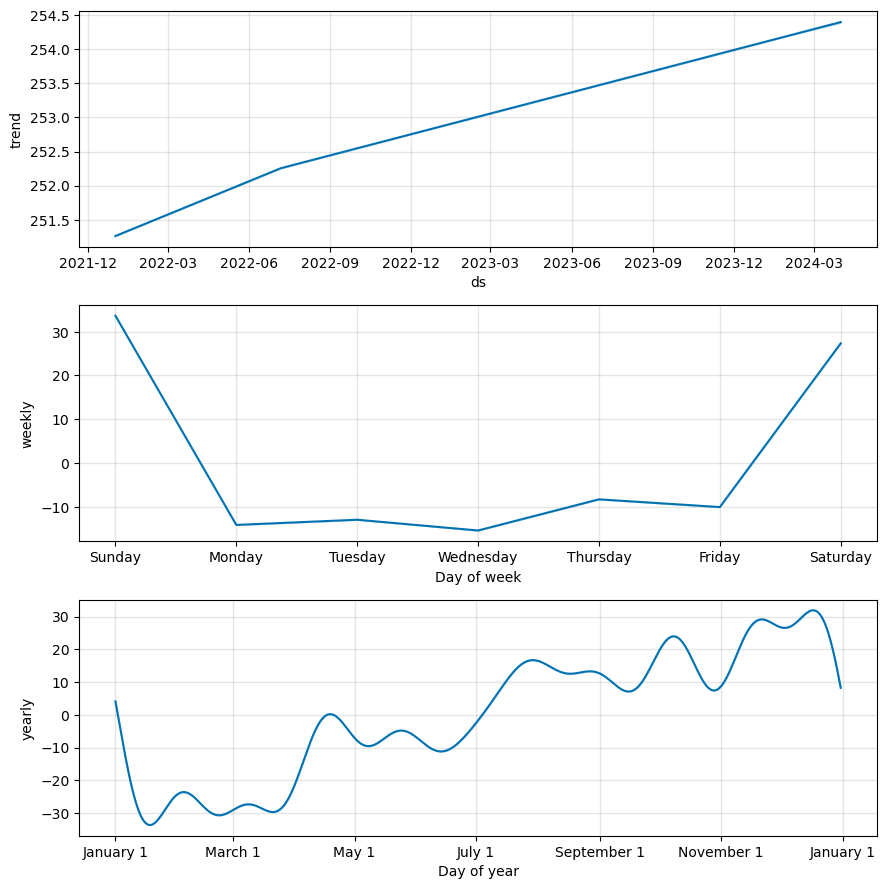

In [27]:
# Plotando gráficos auxiliares para complemento da análise

fig2 = modelo.plot_components(previsao)

### Separando os dados de treino e teste para melhorar a previsão

Para trabalhar com séries temporais e testar os modelos de previsão até encontrar a mais próxima dos dados, será feita a divisão do dataframe já conhecido em treino e teste, para verificar de forma mais precisa o índice de acerto do modelo utilizando a biblioteca Prophet.

In [28]:
# Identificando a quantidade de observações para fazer a separação de 80% do dados para treino e o restante para teste 

df_tempo.shape

(731, 2)

In [29]:
# Criação de Dataframes vazios para adicionar as devidas separações de treino e teste

df_treino = pd.DataFrame()

df_treino['ds'] = df_tempo['ds'][:584] #80% do dataframe
df_treino['y'] = df_tempo['y'][:584]


df_teste = pd.DataFrame()

df_teste['ds'] = df_tempo['ds'][584:] # 20% do dataframe
df_teste['y'] = df_tempo['y'][584:]

In [54]:
# Treinando o modelo utilizando Prophet tendo como base a mesma seed setada anterioremente

np.random.seed(3476)

modelo = Prophet()
modelo.fit(df_treino)
futuro = modelo.make_future_dataframe(periods=147, freq='D')
previsao = modelo.predict(futuro)

21:23:49 - cmdstanpy - INFO - Chain [1] start processing
21:23:49 - cmdstanpy - INFO - Chain [1] done processing


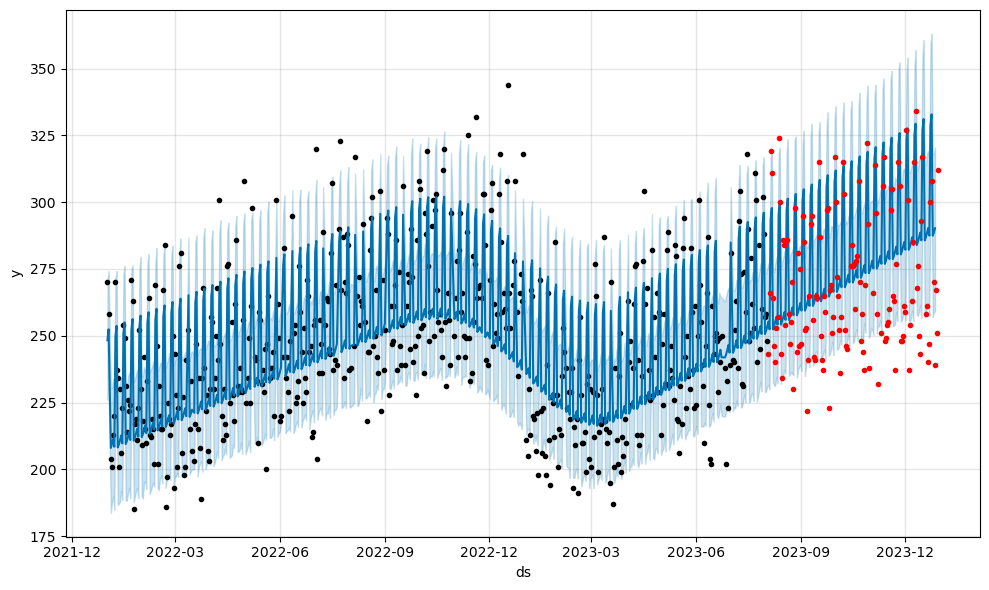

In [55]:
# Plotando o resultado obtido

fig1 = modelo.plot(previsao)
plt.plot(df_teste['ds'], df_teste['y'], '.r')

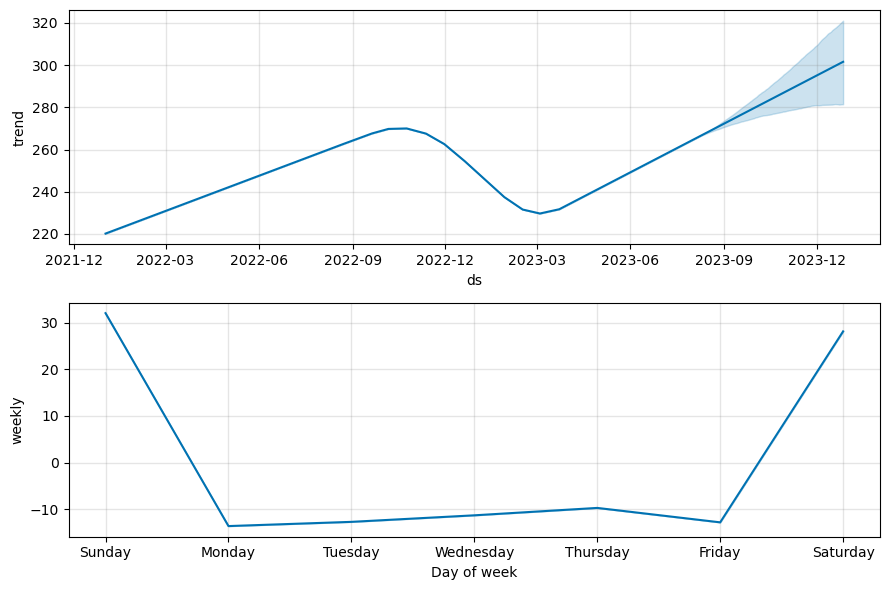

In [56]:
fig2 = modelo.plot_components(previsao)

In [57]:
# Comparação entre valores previstos pelo modelo e os valores reais 

df_previsao = previsao[['ds','yhat']]
df_comparacao = pd.merge(df_previsao,df_teste, on = 'ds')
df_comparacao

,ds,yhat,y
0,2023-08-03,255.281657,243
1,2023-08-04,252.435870,266
2,2023-08-05,293.664371,319
3,2023-08-06,297.826786,311
4,2023-08-07,252.387532,264
...,...,...,...
128,2023-12-22,287.490769,247
129,2023-12-23,328.719270,300
130,2023-12-24,332.881685,308
131,2023-12-26,288.597756,270


Analisando os dados, é possível entender que o modelo não considerou a questão da sazonalidade, deixando muito a desejar. Para estabecer uma estimativa para que sirva de comparação aos próximos modelos irei utilizar outra biblioteca para obter o indicador dos erros da previsão

In [58]:
# Encontrando a média de erro quadrático

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 471.3359119104211, RMSE: 21.71027203676686


O modelo conseguiu manter uma faixa de relativamente próxima entre as observações reais e as previstas. Porém, como a base de dados nos permite adicionar o fator sazonalidade, é possível aprimorar a análise incluindo o parâmetro anual.

In [59]:
# Adicionando parâmetro anual da biblioteca do Prophet dentro do modelo, essa biblioteca é capaz de interpretar sazonalidade
# semanal ou diária, a dependender da base de dados sendo utilizada para estudo

np.random.seed(3476)

modelo = Prophet(yearly_seasonality = True)

modelo.fit(df_tempo)
futuro = modelo.make_future_dataframe(periods=147,freq='D')
previsao = modelo.predict(futuro)

21:24:34 - cmdstanpy - INFO - Chain [1] start processing
21:24:34 - cmdstanpy - INFO - Chain [1] done processing


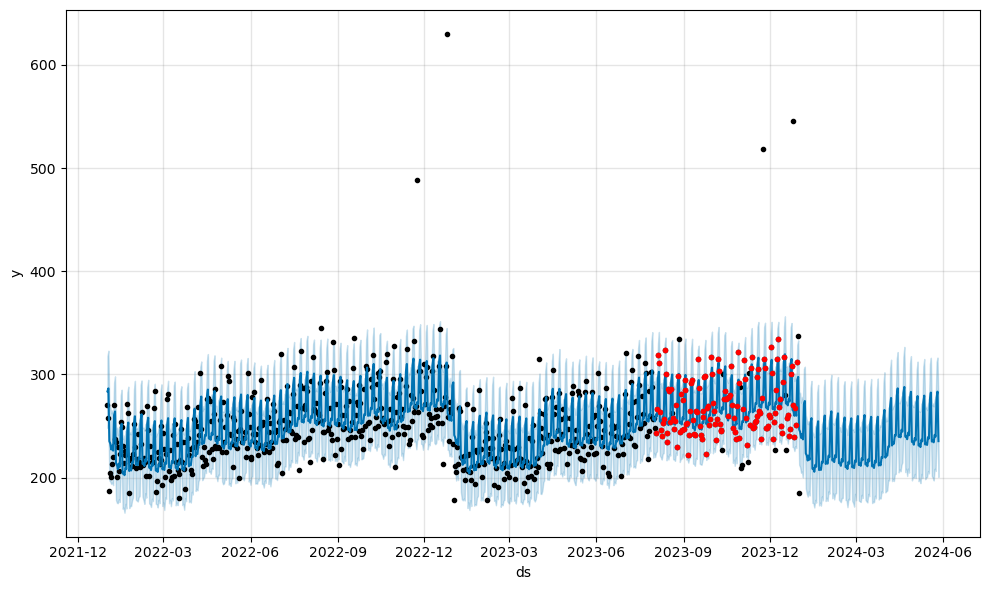

In [60]:
fig1 = modelo.plot(previsao)
plt.plot(df_teste['ds'], df_teste['y'], '.r')

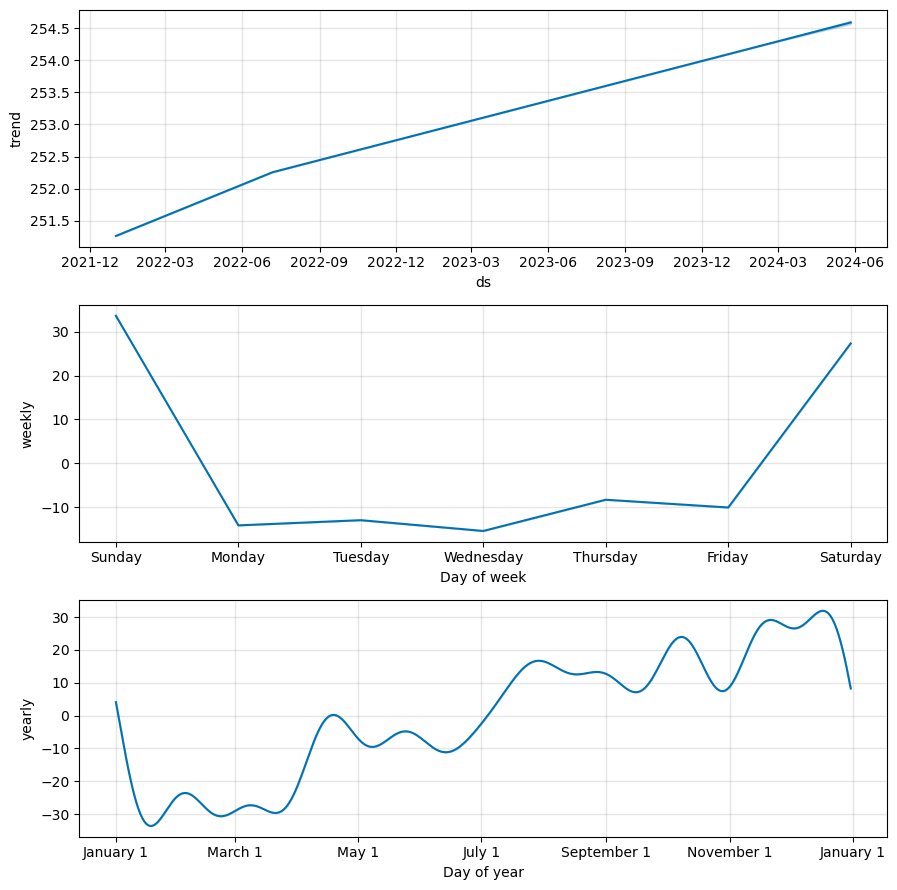

In [61]:
fig2 = modelo.plot_components(previsao)

In [62]:
df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds')
df_comparacao

,ds,yhat,y
0,2023-08-03,261.430224,243
1,2023-08-04,259.401277,266
2,2023-08-05,296.513534,319
3,2023-08-06,302.489870,311
4,2023-08-07,254.355644,264
...,...,...,...
131,2023-12-26,264.579751,270
132,2023-12-27,259.853063,239
133,2023-12-28,264.452254,267
134,2023-12-29,259.937609,251


In [63]:
# Encontrar a média de erro quadrático

mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'MSE: {mse}, RMSE: {rmse}')

MSE: 235.1866003493094, RMSE: 15.33579474136601


Ao adicionar o parâmetro de sazonalidade anual, o modelo teve uma acurácia muito melhor, tornando o modelo mais confiável para previsão. Porém para tentar ajustar ainda mais o modelo de previsão, existe a possibilidade de remover valores estão fora do intervalo de confiança. No caso deste dataframe, há dias específicos de vendas massivas e eles podem ser tratados em outra oportunidade, vez que o objetivo do estudo é prever valores que sirvam para o ano inteiro. Para isso será necessário polir novamente o dataframe que está sendo usado.

In [85]:
# Adaptando novamente o dataframe ao modelo tendo como o parâmetro 'periods' igual a 0 para que a previsão fique limitada
# apenas aos dados já conhecidos

np.random.seed(3476)

modelo = Prophet()
modelo.fit(df_tempo)
futuro = modelo.make_future_dataframe(periods = 0)
previsao = modelo.predict(futuro)

21:48:59 - cmdstanpy - INFO - Chain [1] start processing
21:48:59 - cmdstanpy - INFO - Chain [1] done processing


In [86]:
# Removendo outliers que estão fora do intervalo de confiança (yhat_lower, yhat_upper)

sem_outliers = df_tempo[(df_tempo['y'] > previsao['yhat_lower']) & (df_tempo['y'] < previsao['yhat_upper'])].reset_index()

In [87]:
sem_outliers

,index,ds,y
0,0,2022-01-01,270
1,1,2022-01-02,258
2,3,2022-01-04,204
3,4,2022-01-05,201
4,5,2022-01-06,213
...,...,...,...
675,724,2023-12-26,270
676,725,2023-12-27,239
677,726,2023-12-28,267
678,727,2023-12-29,251


Com isso, o dataframe foi reduzido para 680 observações e assim é esperado alcançar um erro ainda menor entre as previsões

In [88]:
# Criando novamente os dataframes para abrigar as amostras de treino e teste

df_treino = pd.DataFrame()

df_treino['ds'] = sem_outliers['ds'][:544] 
df_treino['y'] = sem_outliers['y'][:544]

df_teste = pd.DataFrame()

df_teste['ds'] = sem_outliers['ds'][544:] 
df_teste['y'] = sem_outliers['y'][544:]

In [89]:
# Utilizando a biblioteca Prophet, criando o novo modelo sem outliers e com o fator de sazonalidade anual ativa

np.random.seed(3476)

modelo_sem_outliers = Prophet(yearly_seasonality = True)

modelo_sem_outliers.fit(df_treino)
futuro = modelo_sem_outliers.make_future_dataframe(periods=147, freq='D')
previsao = modelo_sem_outliers.predict(futuro)

21:49:11 - cmdstanpy - INFO - Chain [1] start processing
21:49:11 - cmdstanpy - INFO - Chain [1] done processing


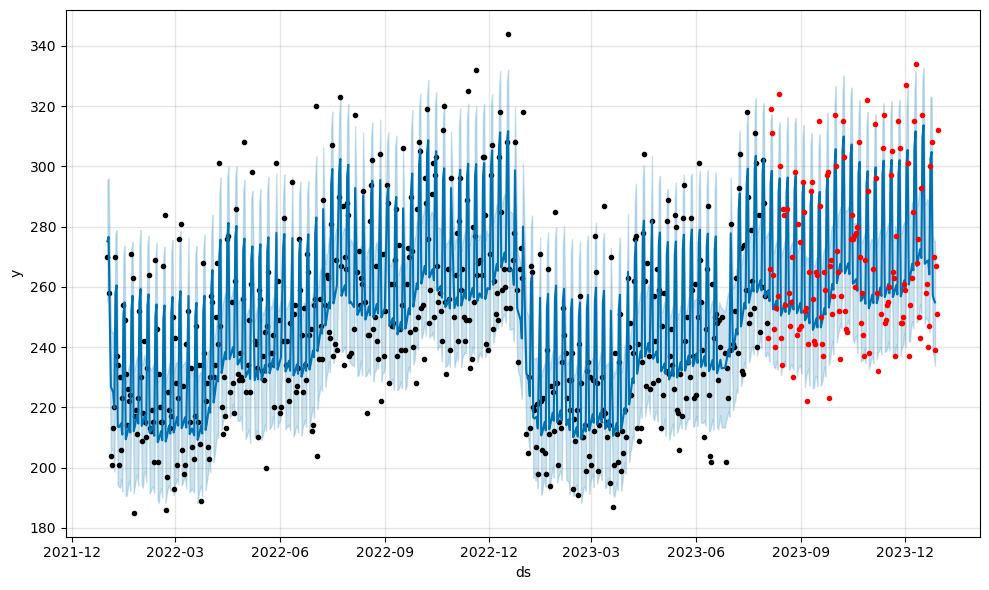

In [90]:
# Plotando novo gráfico utilizando o novo modelo sem outliers

fig1 = modelo_sem_outliers.plot(previsao)
plt.plot(df_teste['ds'], df_teste['y'], '.r')

In [91]:
# Comparando os resultados obtidos

df_previsao = previsao[['ds', 'yhat']]
df_comparacao = pd.merge(df_previsao, df_teste, on='ds')
df_comparacao

,ds,yhat,y
0,2023-08-03,258.935394,243
1,2023-08-04,255.255192,266
2,2023-08-05,294.781069,319
3,2023-08-06,298.543549,311
4,2023-08-07,252.550106,264
...,...,...,...
128,2023-12-22,264.148347,247
129,2023-12-23,302.487131,300
130,2023-12-24,304.810469,308
131,2023-12-26,255.856962,270


In [92]:
mse = mean_squared_error(df_comparacao['y'], df_comparacao['yhat'])
rmse = np.sqrt(mse)

print(f'mse: {mse}, rmse: {rmse}')

mse: 220.08637184616325, rmse: 14.83530828281513


O modelo obteve ganho pouco sigfinicativo em relação ao dataframe utilizado anteriormente, sendo assim, a remoção de outliers não surtiu o efeito desejado.

### Plotagem dos resultados utilizando a biblioteca plotly do modelo Prophet para previsão de vendas de 365 dias

In [96]:
# Plotagem de gráficos interativos das previsões

plot_plotly(modelo, previsao)
plot_components_plotly(modelo, previsao)

In [97]:
# Modelo final de séries temporais utilizando Prophet para o período de 365 dias

np.random.seed(3476)

modelo_sem_outliers = Prophet(yearly_seasonality = True)

modelo_sem_outliers.fit(df_treino)
futuro = modelo_sem_outliers.make_future_dataframe(periods=365, freq='D')
previsao = modelo_sem_outliers.predict(futuro)

21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:50 - cmdstanpy - INFO - Chain [1] done processing


In [98]:
# Plotagem final da previsão de vendas para 365 dias

fig = plot_plotly(modelo_sem_outliers, previsao)
fig.show()

Conclusão: Ao utilizar a biblioteca Prophet para prever as vendas do varejo para o período de 365 dias, adicionar o parâmetro de sazonalidade foi fundamental para melhorar a estimativa de vendas. Remover os outliers do dataframe não trouxe o resultado esperado, sendo pouco relevante para esse contexto. 